# Build CNN with Tensorflow

In [1]:
import tensorflow as tf
import mnist
mn = mnist.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mn.train.images, mn.train.labels, mn.test.images, mn.test.labels

('Extracting', 'MNIST_data/train-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/train-labels-idx1-ubyte.gz')
('Extracting', 'MNIST_data/t10k-images-idx3-ubyte.gz')
('Extracting', 'MNIST_data/t10k-labels-idx1-ubyte.gz')


/usr/local/lib/python2.7.12/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
mnist.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


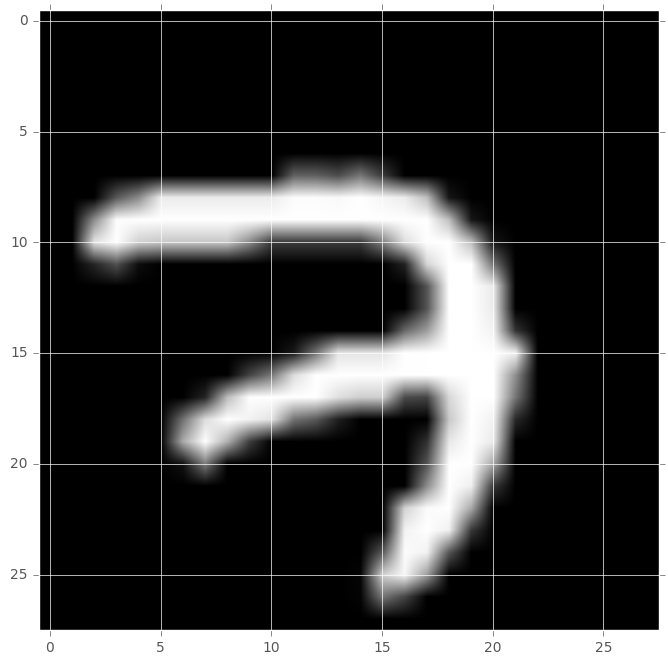

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
rcParams['font.size'] = 20
plt.style.use('ggplot')

plt.imshow(np.array(trX[0]*256, dtype=np.uint8).reshape((28, 28)), cmap='gray')

In [3]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

with tf.device('/gpu:0'):
    X = tf.placeholder("float", [None, 784])
    Y = tf.placeholder("float", [None, 10])
    p_keep_conv = tf.placeholder("float")
    p_keep_hidden = tf.placeholder("float")
    net = tf.reshape(X, [-1, 28, 28, 1])

    ############## size = Bx28x28x1

    w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
    net = tf.nn.conv2d(net, w, strides=[1, 1, 1, 1], padding='SAME')
    net = tf.nn.relu(net)
    net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    net = tf.nn.dropout(net, p_keep_conv)

    ############## size = Bx14x14x32

    w = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
    net = tf.nn.conv2d(net, w, strides=[1, 1, 1, 1], padding='SAME')
    net = tf.nn.relu(net)
    net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    net = tf.nn.dropout(net, p_keep_conv)

    ############## size = Bx7x7x64

    w = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
    net = tf.nn.conv2d(net, w, strides=[1, 1, 1, 1], padding='SAME')
    net = tf.nn.relu(net)
    net = tf.nn.max_pool(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    net = tf.nn.dropout(net, p_keep_conv)

    ############## size = Bx4x4x128

    net = tf.reshape(net, [-1, 2048])

    ############## size = Bx2048

    w = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
    net = tf.matmul(net, w)
    net = tf.nn.relu(net)
    net = tf.nn.dropout(net, p_keep_hidden)

    ############## size = Bx625

    w = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)
    logits = tf.matmul(net, w)

    ############## size = Bx10

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, Y))
    train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
    predict_op = tf.argmax(logits, 1)

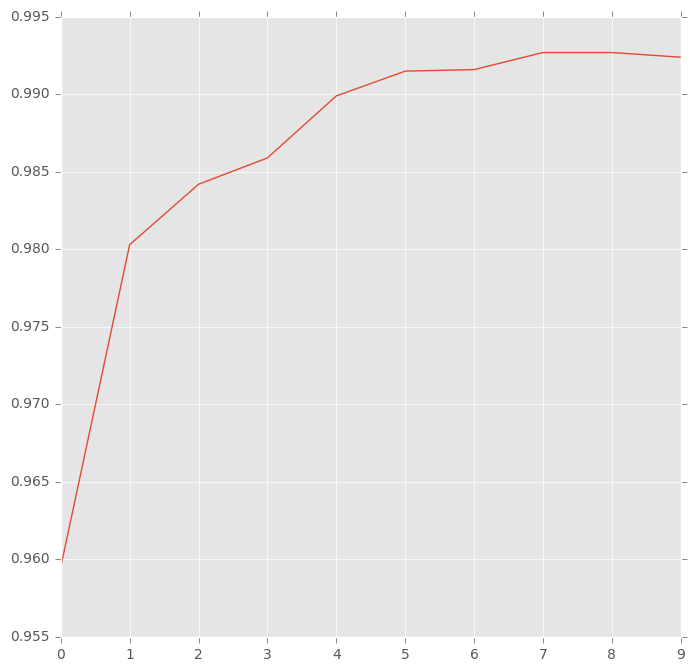

In [6]:
with tf.Session() as sess:
    accu = []
    tf.global_variables_initializer().run()
    batch_size = 128

    for i in range(10):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})

        y = sess.run(predict_op, feed_dict={X: teX, Y: teY, p_keep_conv: 1.0, p_keep_hidden: 1.0})
        accu.append(np.mean(np.argmax(teY, axis=1) == y))

plt.plot(accu)